In [1]:

import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

In [ ]:
def lorentzian(f, f0, hwhm, snr):
    return snr / (1 + ((f - f0) / hwhm)**2)



def gen_spectrum(species='anolis', noise_floor=[], noise_amp=0.01, n_peaks=10, f0_dist='chi'):
    # Get frequency axis
    f = rfftfreq(32768, 1/44100)
    
    # Get num bins in the spectrum
    n_bins = len(noise_floor)
    if n_bins != 8192:
        raise ValueError(f"Expected noise floor to be 8192 bins, but it's {n_bins} bins!")
    
    # Initialize matrix to store all the different peaks to be added to the noisefloor
    spec_components = np.empty((n_peaks + 1, n_bins))
    
    # Add noise floor
    spec_components[-1, :] = noise_floor
    
    # Set generation parameters
    
    # f0: we'll draw half from a chi square
    f0_chi_dof = 10
    f0_chi_og_pivot = 20 # This is the value of the original distribution that we want to "grab"
    f0_chi_new_pivot = 8000 # We'll rescale ("pull") the distribution so that that value becomes this value
    # and the other half from a uniform distribution
    f0_min = 50
    f0_max = 6000
    
    # hwhm: we'll draw from uniform distribution
    if species == 'Anolis':
        hwhm_min = 25
        hwhm_max = 125
    elif species == 'Human':
        hwhm_min = 3
        hwhm_max = 15
    elif species == 'General':
        hwhm_min = 3
        hwhm_mx = 15

    # SNR: we'll draw from a uniform distribution
    snr_min = 0
    snr_max = 25
    
    # Create a Generator instance
    rng = np.random.default_rng()  # Default random generator instance
    
    # Generate and add peaks
    for i in range(n_peaks):
        # f0
        # Draw the positions from a chi square
        if f0_dist == 'chi':
            f0 = rng.chisquare(df=f0_chi_dof)*f0_chi_new_pivot/f0_chi_og_pivot
            # make sure it's below our spectral max, resample if not
            while f0 > f[-1]:
                f0 = rng.chisquare(df=f0_chi_dof)*f0_chi_new_pivot/f0_chi_og_pivot

        
        # hwhm
        hwhm = rng.uniform(hwhm_min, hwhm_max)
        
        # SNR
        snr = rng.uniform(snr_min, snr_max)
        
        # Add peak
        spec_components[i, :] = lorentzian(f, f0, hwhm, snr)
        

        
        

In [ ]:
# Parameters for the chi-square distribution
f0_chi_dof = 10  # k (degrees of freedom)
num_samples = 10000     # Number of samples to generate

# Generate samples from a chi-square distribution
f0_chi_og_pivot = 20
f0_chi_new_pivot = 6000
chi_square_samples = np.random.chisquare(df=f0_chi_dof, size=num_samples)*f0_chi_new_pivot/f0_chi_og_pivot

# Plot the histogram of the samples
plt.hist(chi_square_samples, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Chi-Square Distribution (k={f0_chi_dof})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
f = rfftfreq(32768, 1/44100)
f0 = 5000
snr = 1
hwhm = 1000

plt.plot(f, lorentzian(f, f0, hwhm, snr))
plt.show()

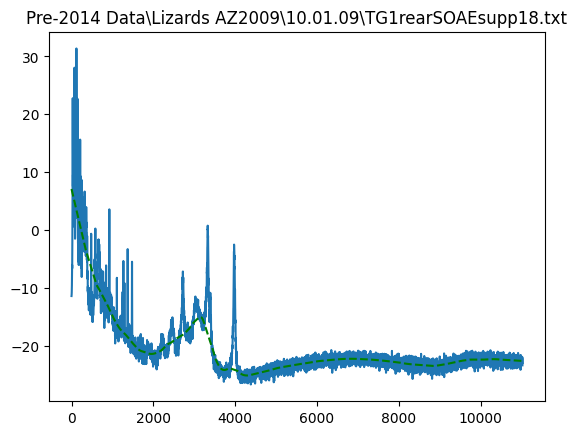

[  7.0968225    7.05598418   7.0151467  ... -22.58071135 -22.58137315
 -22.58203577]


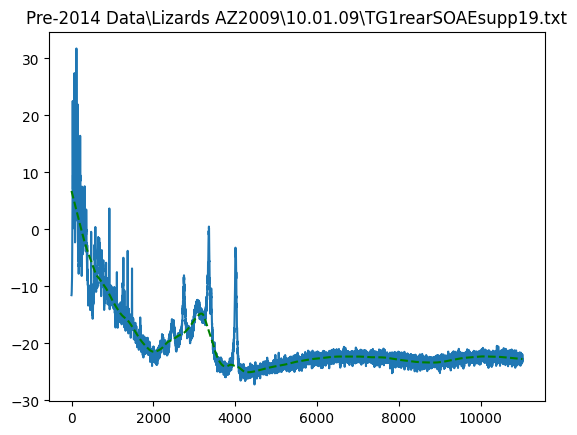

[  6.74323436   6.70460646   6.66598324 ... -22.73782491 -22.73880805
 -22.73979138]


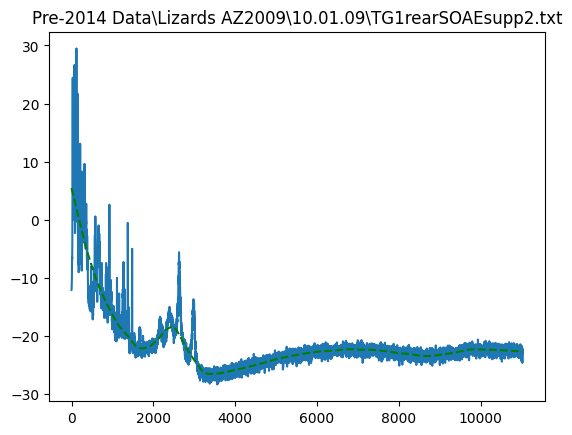

[  5.47669565   5.43716336   5.39763347 ... -22.65522544 -22.65602333
 -22.65682155]


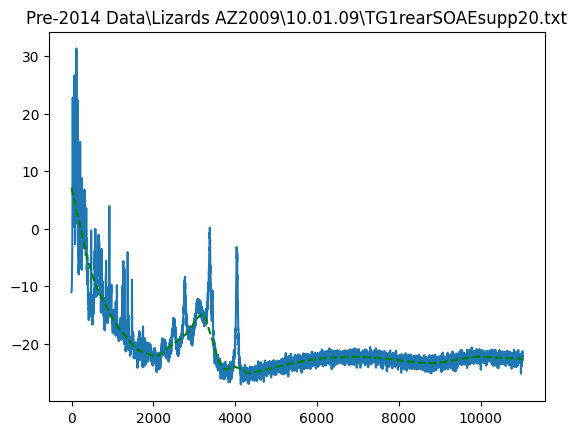

[  7.12010255   7.07659015   7.03307591 ... -22.59454435 -22.59489496
 -22.59524515]


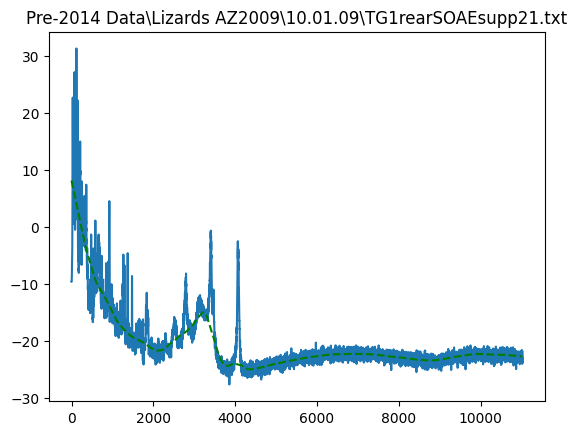

[  8.15690258   8.11089346   8.06488764 ... -22.69048677 -22.69154917
 -22.69261302]


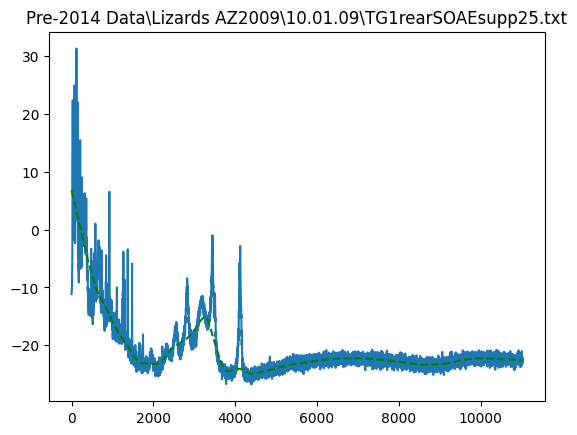

[  6.77986292   6.73900352   6.69814367 ... -22.61967625 -22.62040273
 -22.62112968]


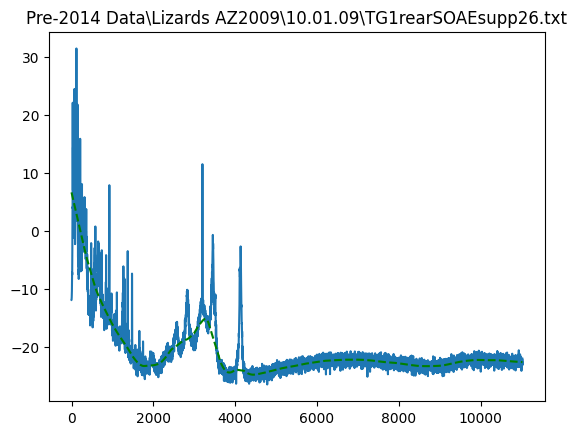

[  6.6298714    6.58886128   6.54784853 ... -22.6436633  -22.64431964
 -22.64497689]


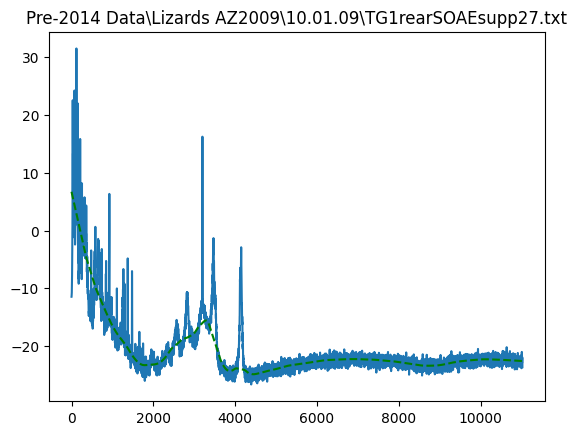

[  6.72068393   6.67780179   6.634918   ... -22.58710513 -22.58761992
 -22.58813435]


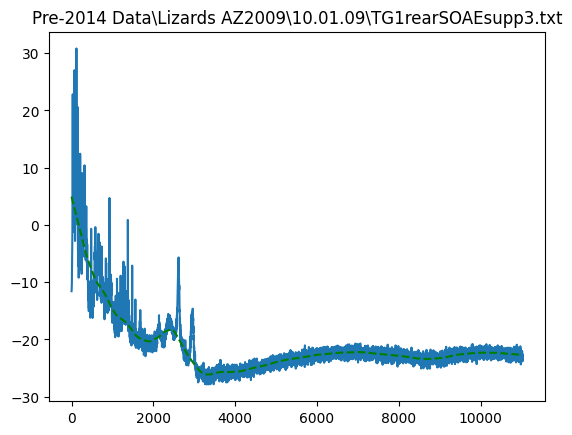

[  4.9456227    4.90759609   4.86956831 ... -22.68927809 -22.68994057
 -22.69060324]


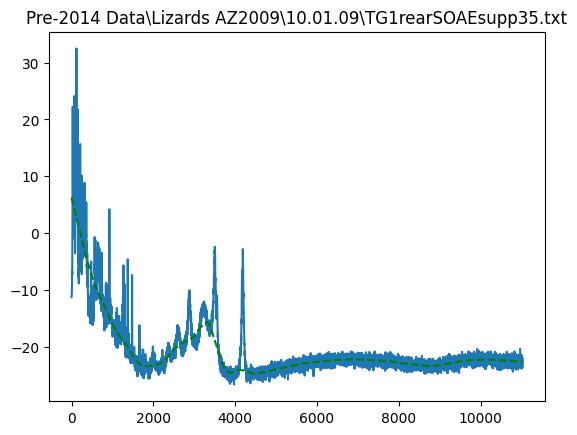

[  6.26594479   6.22658456   6.18722371 ... -22.72535515 -22.72630445
 -22.72725217]


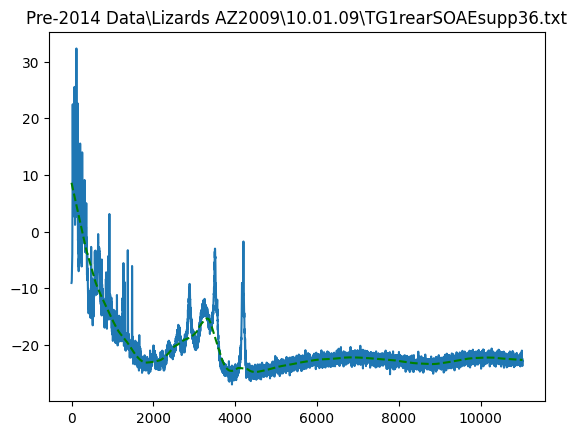

[  8.62506535   8.58040715   8.53574928 ... -22.62688003 -22.62750726
 -22.62813463]


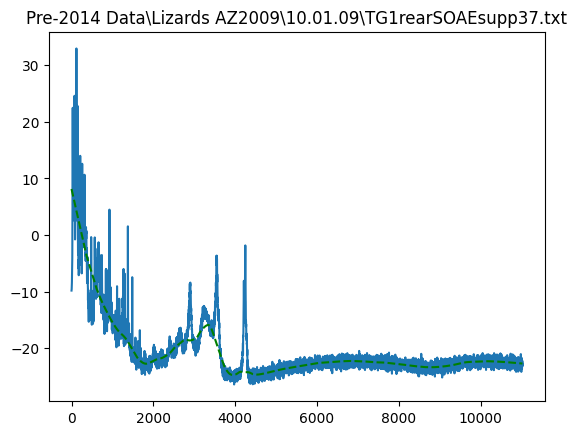

[  8.12135329   8.07780196   8.03424709 ... -22.69124583 -22.69203348
 -22.69282085]


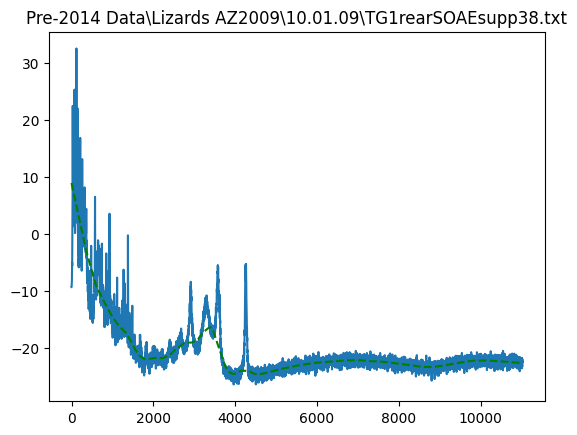

[  8.94685168   8.90179668   8.85673985 ... -22.72203475 -22.72288792
 -22.72374152]


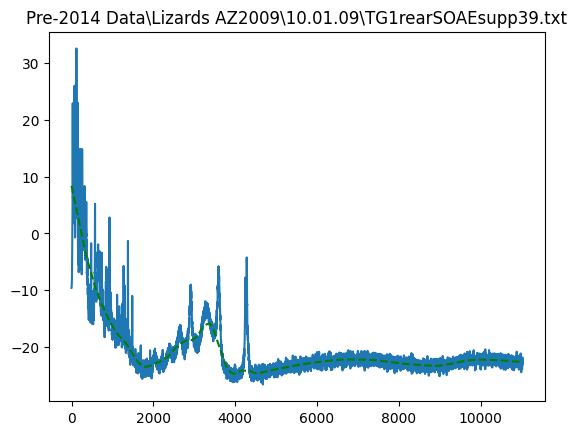

[  8.40553291   8.35892788   8.31231882 ... -22.66893834 -22.66956658
 -22.67019424]


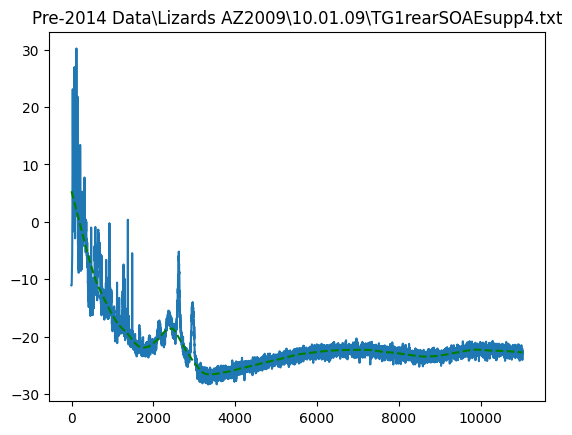

[  5.33611028   5.29932256   5.262532   ... -22.71976909 -22.72049726
 -22.72122541]


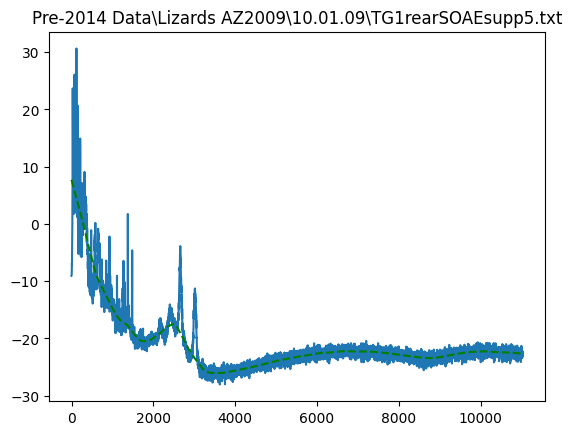

[  7.69456126   7.65906876   7.62357276 ... -22.66689435 -22.66772307
 -22.66855188]


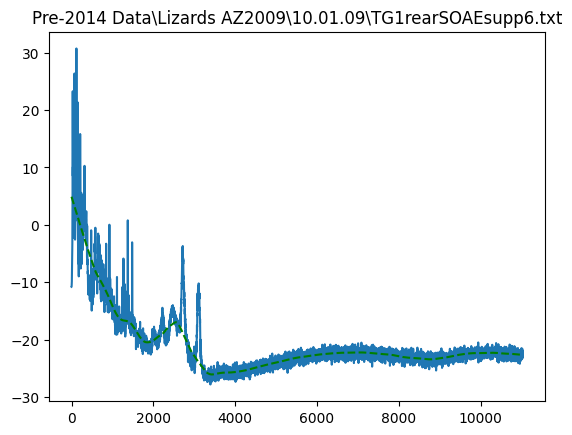

[  4.89760911   4.86604372   4.83448361 ... -22.65969734 -22.66064939
 -22.66160194]


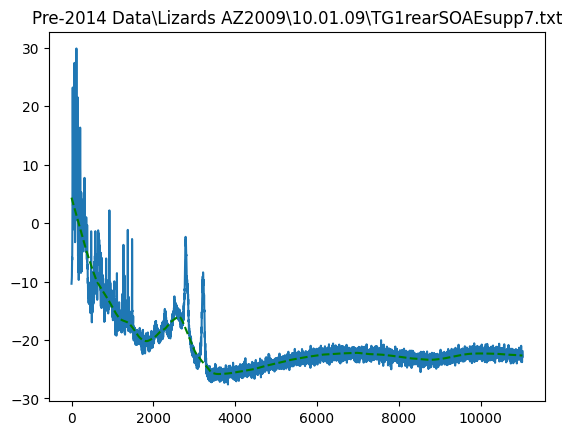

[  4.36307428   4.32915477   4.29523591 ... -22.66188481 -22.66257547
 -22.66326717]


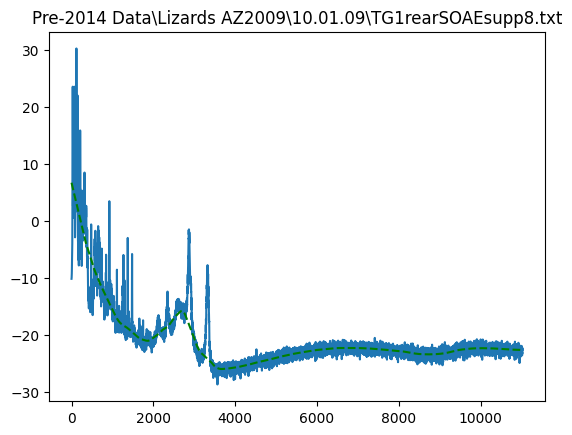

[  6.75140859   6.7105758    6.66974209 ... -22.61748486 -22.61776415
 -22.61804358]


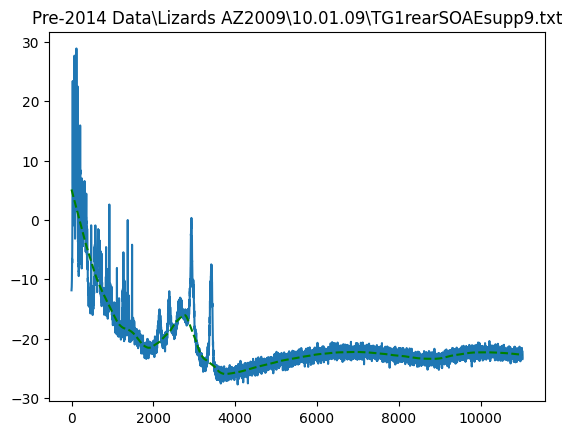

[  5.14003126   5.1049335    5.06983472 ... -22.71829014 -22.71923599
 -22.72018151]


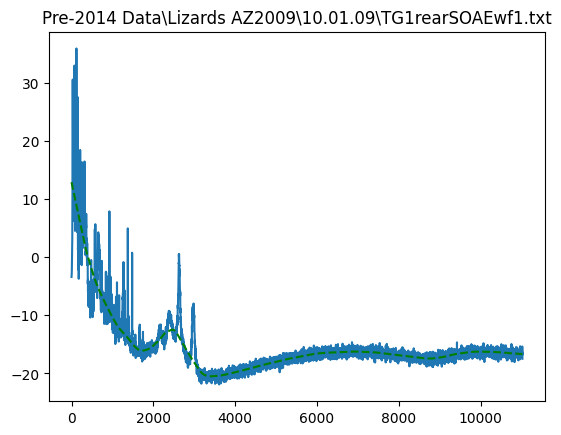

[ 12.86981872  12.82501116  12.78020541 ... -16.67396846 -16.67454818
 -16.67512823]


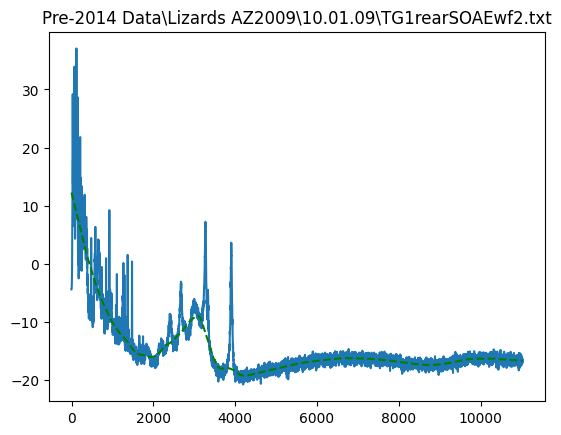

[ 12.27730427  12.2383903   12.199475   ... -16.62401842 -16.62452113
 -16.62502283]


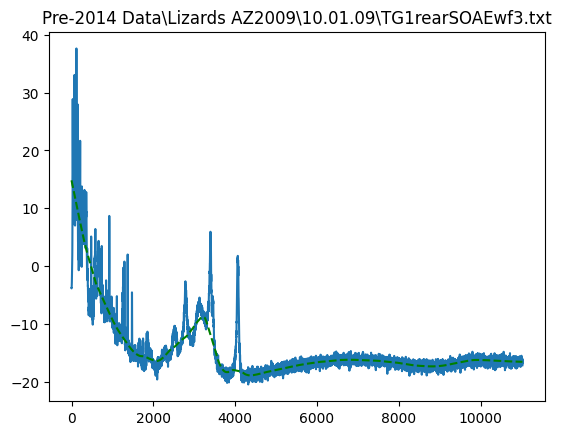

[ 14.83797866  14.79095529  14.74393968 ... -16.55626094 -16.5565809
 -16.55690179]


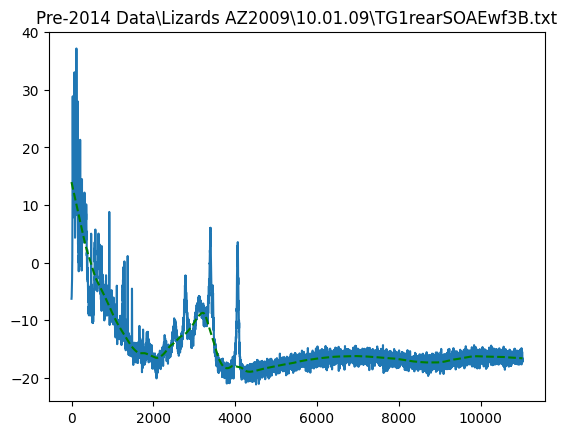

[ 13.97717414  13.93315441  13.88913983 ... -16.60596273 -16.60653174
 -16.6071013 ]


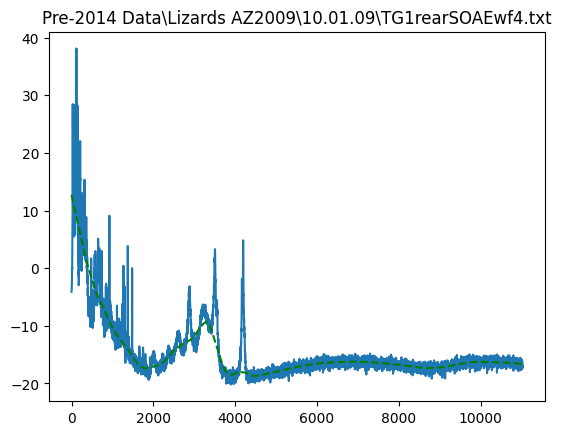

[ 12.71910653  12.67623314  12.63335838 ... -16.65498368 -16.65619289
 -16.65740309]


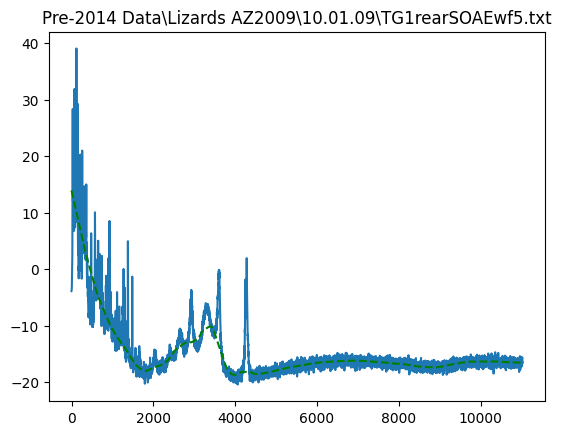

[ 13.92108559  13.87765697  13.83422855 ... -16.55724986 -16.55760657
 -16.55796327]


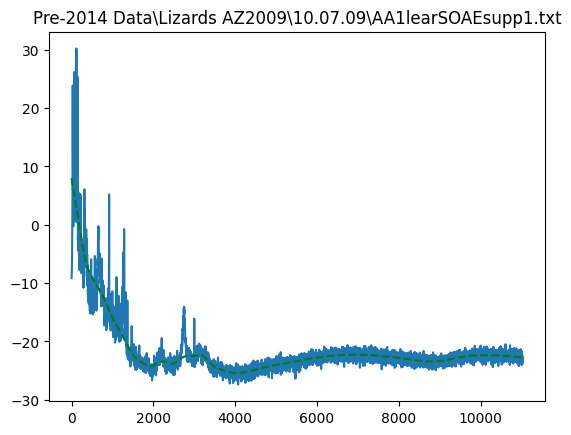

[  7.96568407   7.9077302    7.84978258 ... -22.76687735 -22.76808013
 -22.76928301]


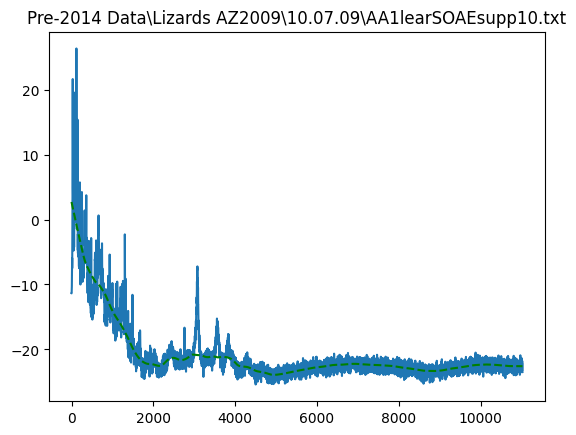

[  2.71274971   2.6727031    2.63266944 ... -22.58291168 -22.58296619
 -22.58302148]


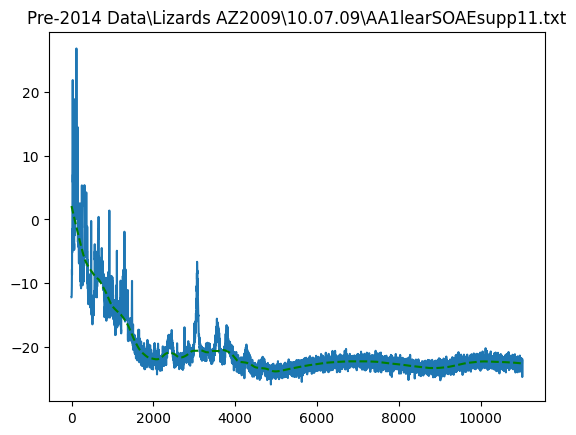

[  2.10934051   2.07117629   2.03302742 ... -22.63647949 -22.63727455
 -22.6380698 ]


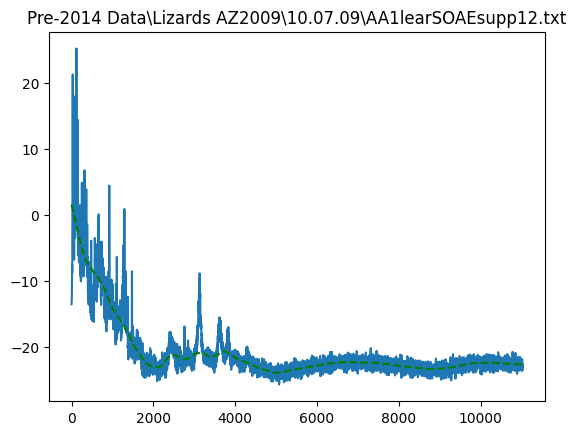

[  1.61440409   1.57730629   1.54022618 ... -22.62305747 -22.62351851
 -22.62398041]


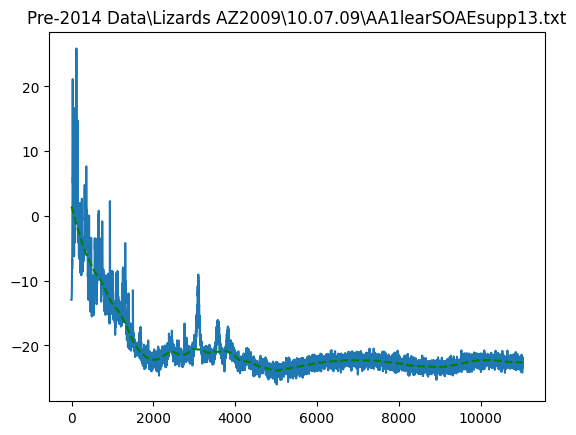

[  1.4591848    1.42873547   1.39829434 ... -22.63042381 -22.63082479
 -22.63122611]


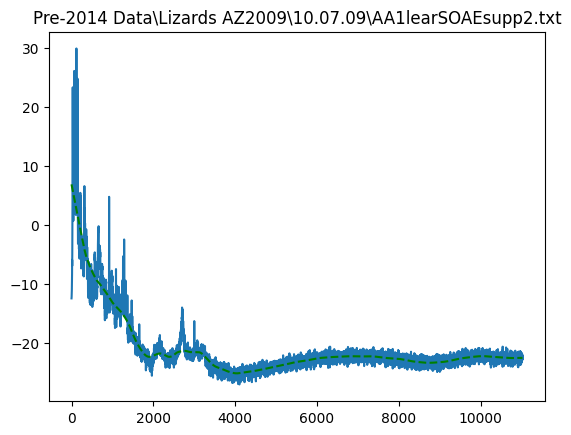

[  6.84256916   6.79427253   6.74598025 ... -22.57303685 -22.57280527
 -22.57257286]


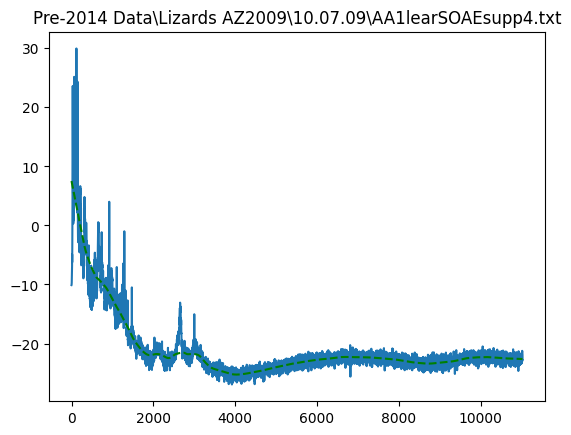

[  7.50884962   7.46090067   7.41295738 ... -22.61934765 -22.61980198
 -22.62025687]


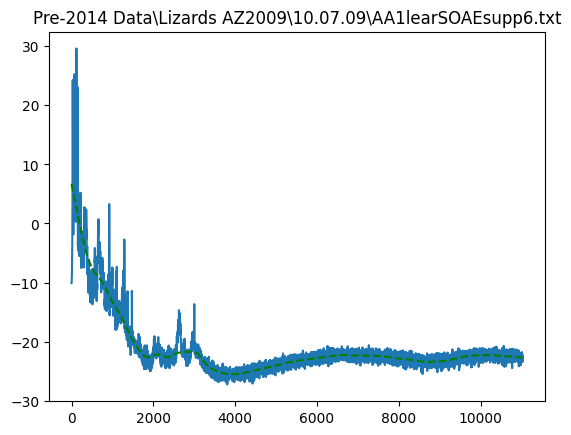

[  6.72561098   6.67920856   6.63281151 ... -22.71962975 -22.72062069
 -22.72161249]


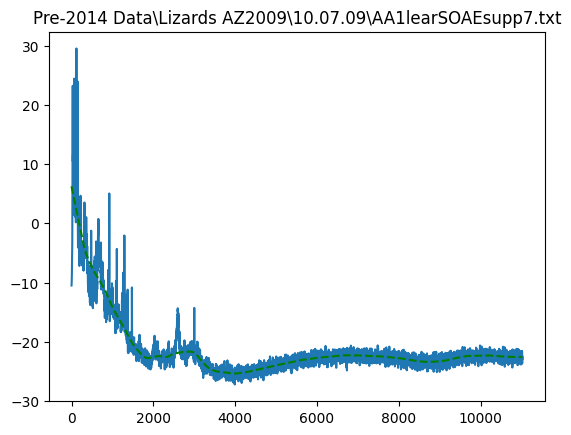

[  6.25932941   6.2133629    6.16740343 ... -22.61049524 -22.61083901
 -22.61118429]


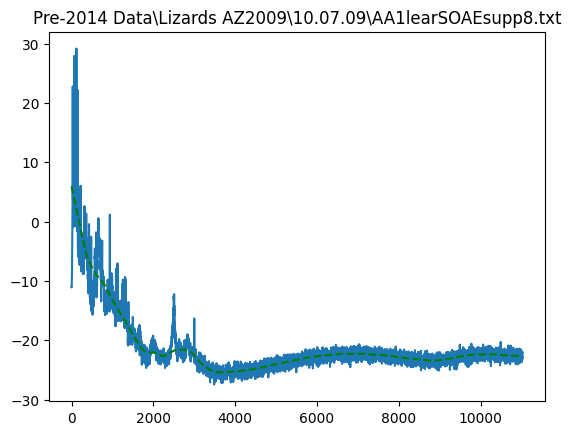

[  5.95912119   5.91565244   5.87218201 ... -22.71864586 -22.71938859
 -22.72013162]


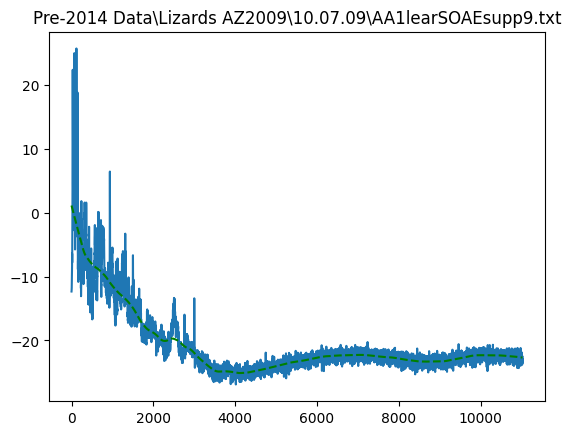

[  1.14233184   1.10865505   1.07498661 ... -22.67763856 -22.67877282
 -22.67990842]


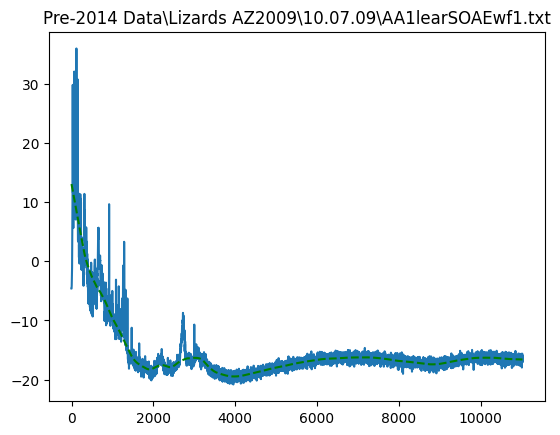

[ 13.06696229  13.01570107  12.96444378 ... -16.60515314 -16.60538166
 -16.60560957]


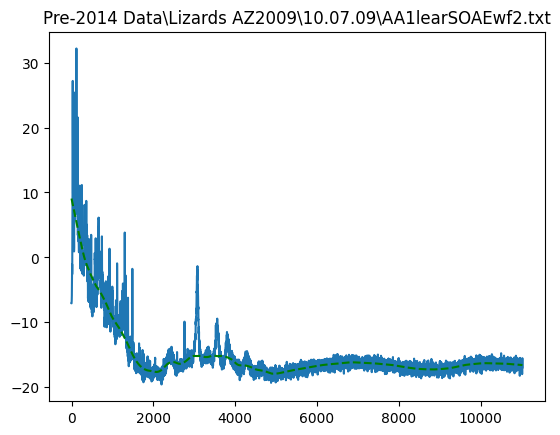

[  9.06570051   9.02408722   8.98248628 ... -16.59694327 -16.59753342
 -16.59812313]


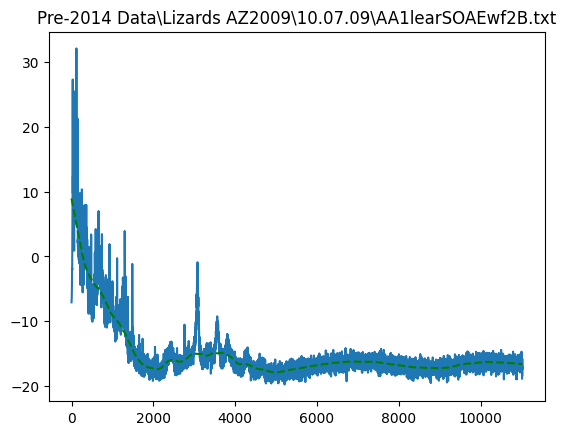

[  8.95201131   8.90648469   8.8609741  ... -16.62603783 -16.6267672
 -16.62749679]


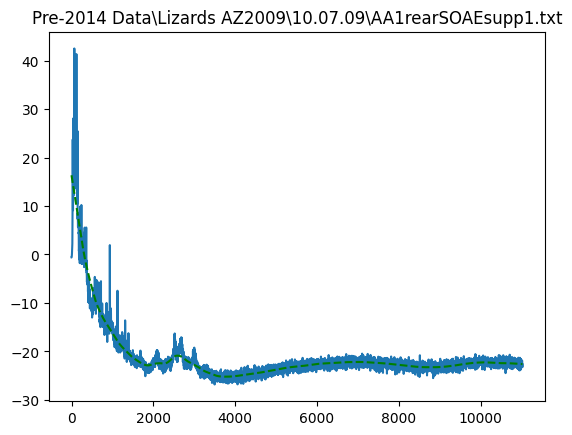

[ 16.34150769  16.26879548  16.196089   ... -22.59770566 -22.59843851
 -22.59917129]


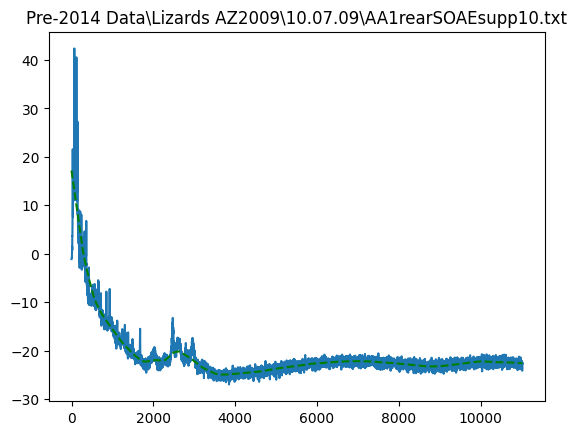

[ 17.1703969   17.08855896  17.00673423 ... -22.59309982 -22.59377297
 -22.59444699]


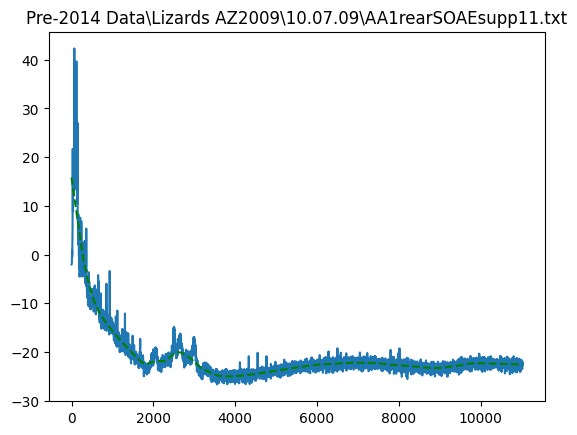

[ 15.81848357  15.73861599  15.65876187 ... -22.63072674 -22.63150765
 -22.63228824]


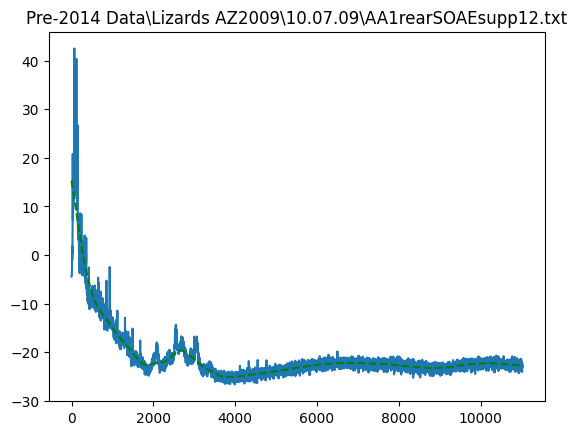

[ 15.32695679  15.25147487  15.17600527 ... -22.73932961 -22.74022523
 -22.74112106]


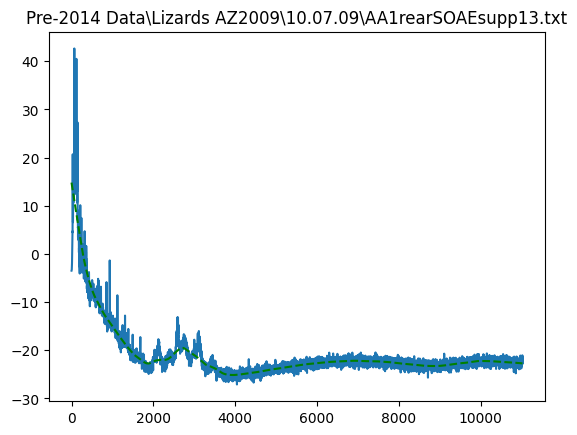

[ 14.81498422  14.74106324  14.66715836 ... -22.71203031 -22.71298852
 -22.71394617]


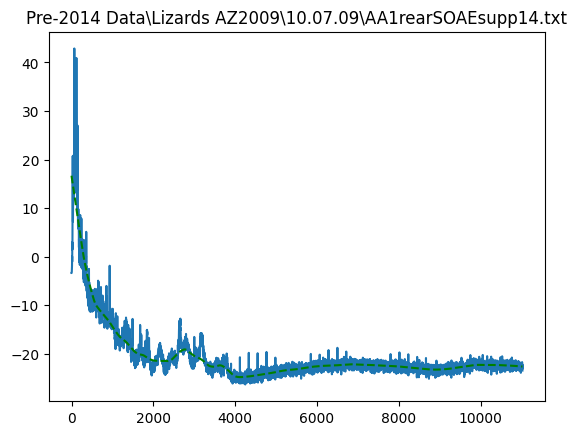

[ 16.68040457  16.60290647  16.52541629 ... -22.60618542 -22.60709599
 -22.60800825]


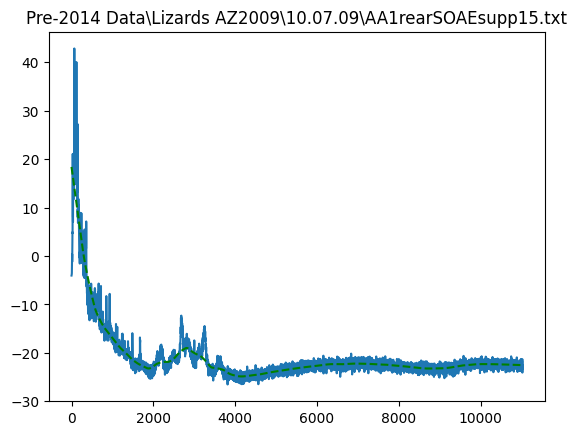

[ 18.39492378  18.31076897  18.22661605 ... -22.54649224 -22.54688936
 -22.54728668]


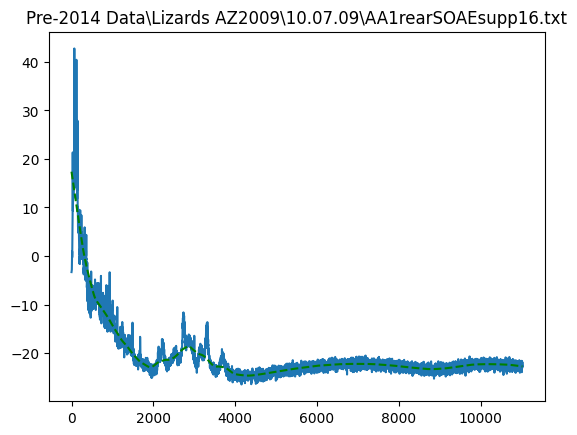

[ 17.37791013  17.29945924  17.22102203 ... -22.75581726 -22.75735234
 -22.75888737]


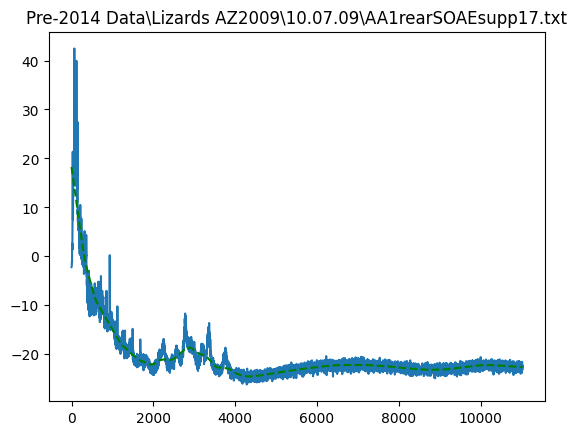

[ 18.24202763  18.16013858  18.07826286 ... -22.62801627 -22.62873706
 -22.62945712]


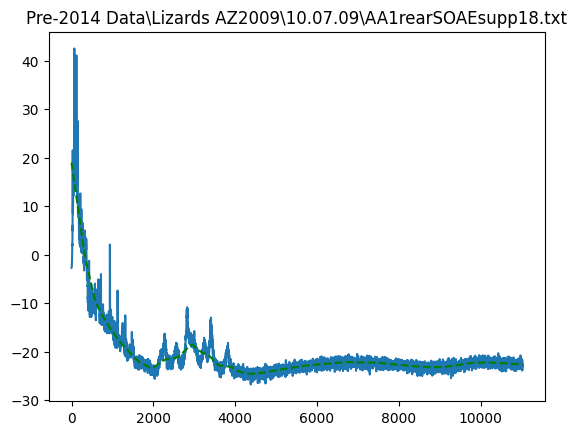

[ 18.99856597  18.91807301  18.83758023 ... -22.68548719 -22.68641531
 -22.68734373]


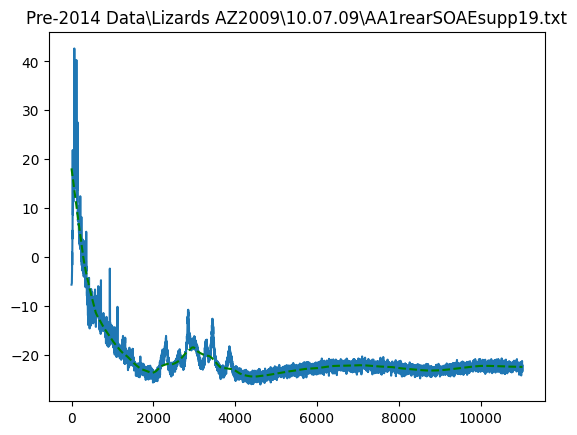

[ 18.11511249  18.02764026  17.94018119 ... -22.53377635 -22.53415775
 -22.53454047]


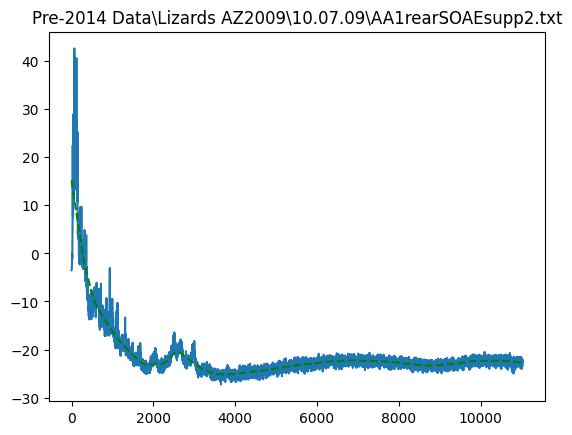

[ 15.14369781  15.0673228   14.99095801 ... -22.65644127 -22.65725291
 -22.65806389]


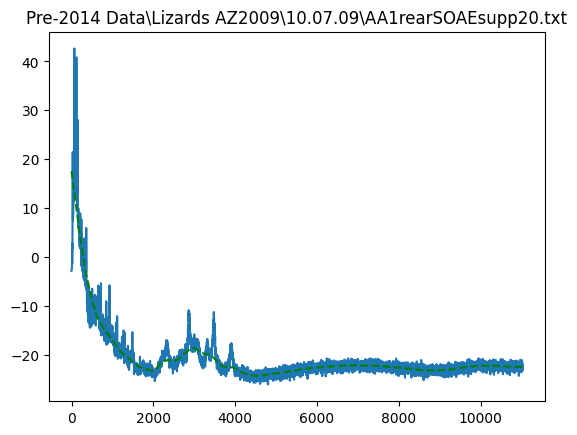

[ 17.53378329  17.44760739  17.36143998 ... -22.54550133 -22.54564465
 -22.54578713]


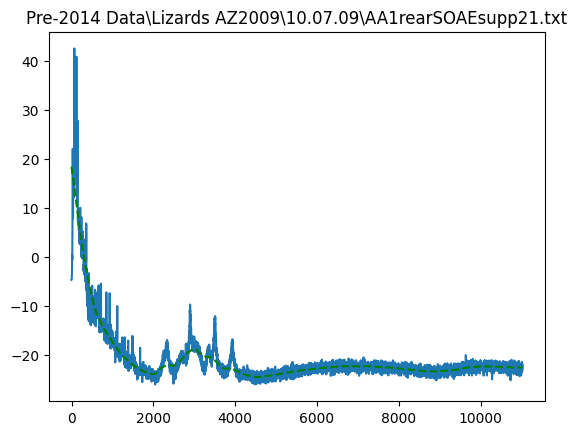

[ 18.46065175  18.37536712  18.29009362 ... -22.49154388 -22.49192938
 -22.4923153 ]


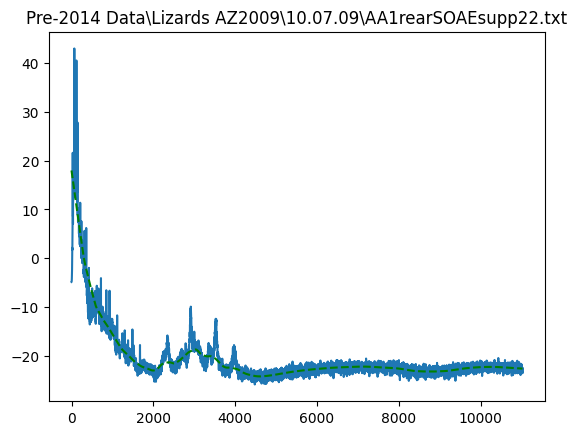

[ 17.98864389  17.90627978  17.82392269 ... -22.622751   -22.62369658
 -22.62464292]


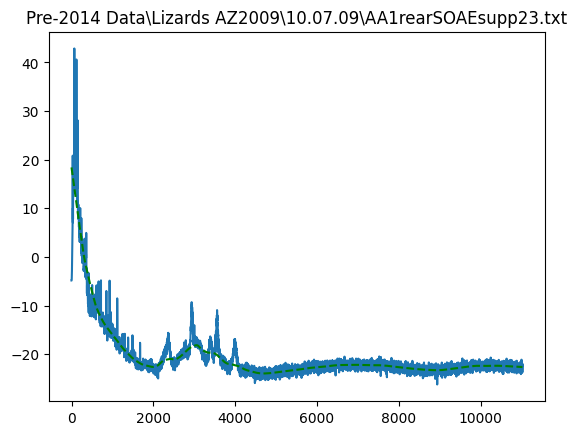

[ 18.40983907  18.32636924  18.24290856 ... -22.61809076 -22.61856218
 -22.61903215]


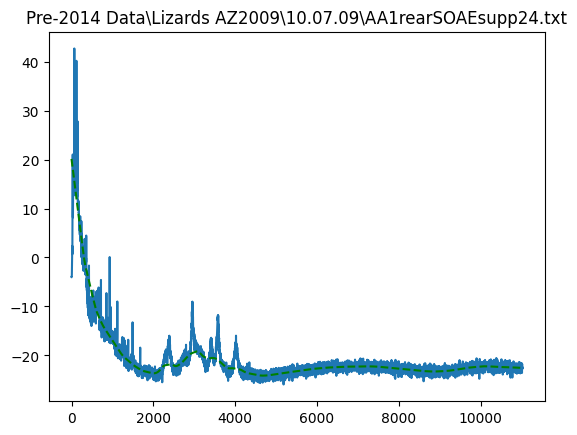

[ 20.12666982  20.03588213  19.94509656 ... -22.53941293 -22.53983126
 -22.54024807]


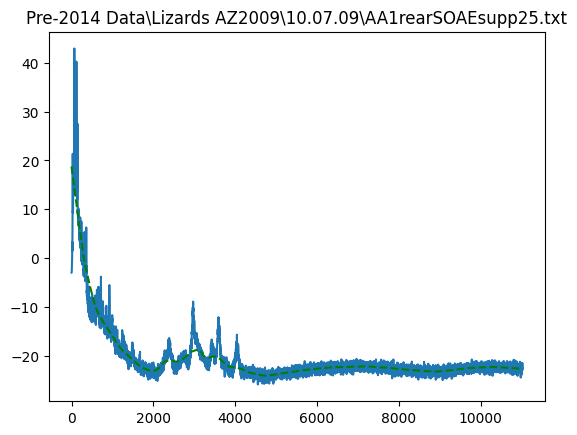

[ 18.75563352  18.66872356  18.58182506 ... -22.66460553 -22.66515498
 -22.66570242]


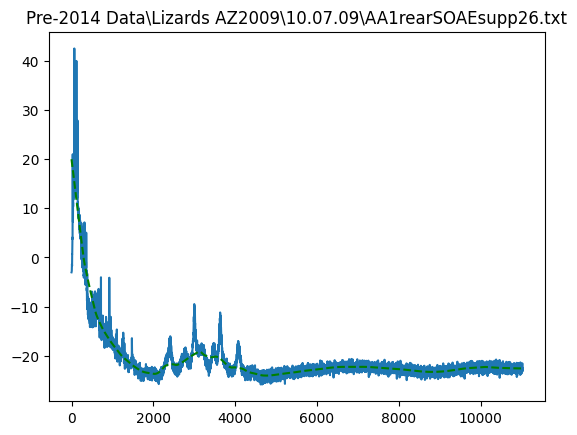

[ 19.94713847  19.8540396   19.76094283 ... -22.54218595 -22.54233061
 -22.54247501]


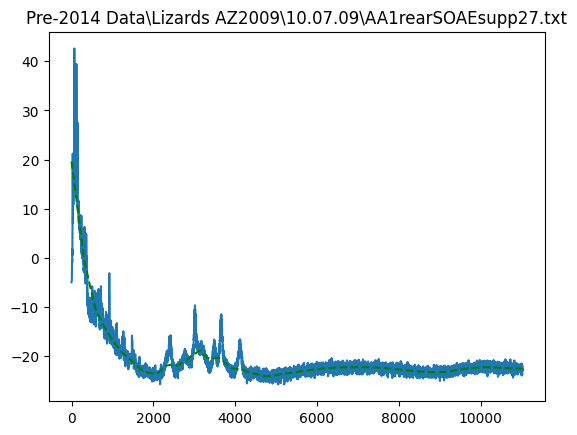

[ 19.61866521  19.53108785  19.44350625 ... -22.55561257 -22.55587934
 -22.55614545]


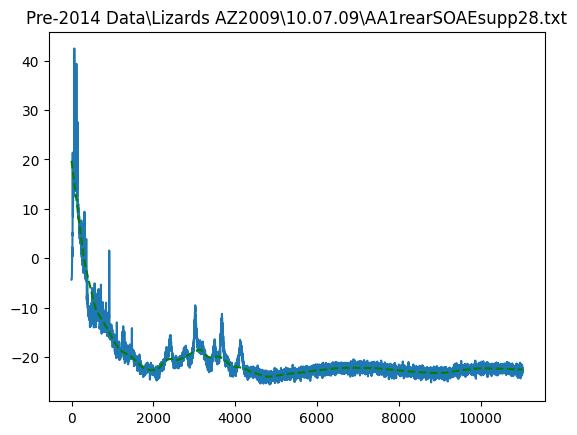

[ 19.72630141  19.63671672  19.54713574 ... -22.55102549 -22.55134363
 -22.55166049]


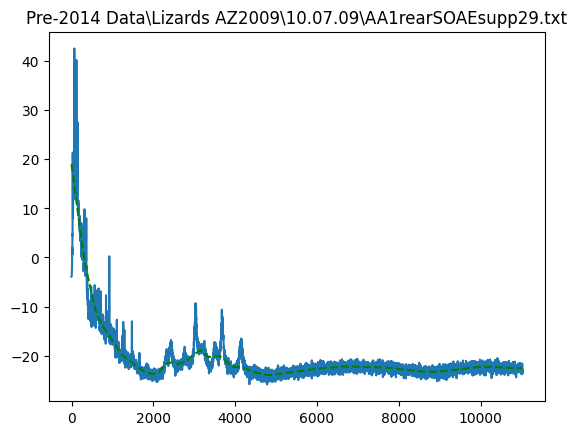

[ 18.99788358  18.91212091  18.8263592  ... -22.5938213  -22.59417771
 -22.59453392]


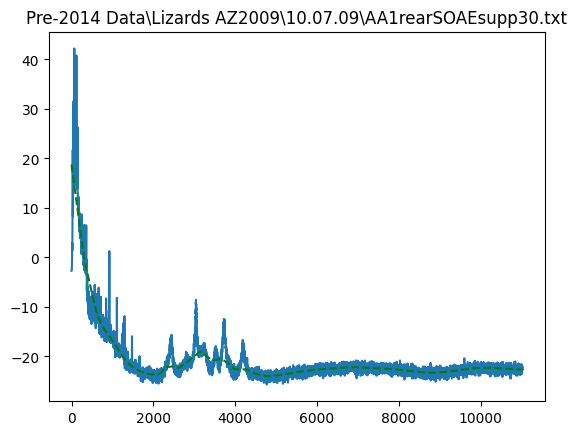

In [ ]:
import statsmodels.api as sm
import pandas as pd
import os

# Get noise floor files

# Get frequency axis
f = rfftfreq(32768, 1/44100)[0:8192]

# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# === deal w/ loess
lowess = sm.nonparametric.lowess
sigma= 0.05  # local-ness factor {0.1-0.2}

i = 0

spectrums = df['spectrum'].to_list()
filepaths = df['filepath'].to_list()

for spectrum, filepath in zip(spectrums, filepaths):
    i+=1
    if i < 2010:
        continue
    
    if i > 2020:
        break
    if i < 2011:
        fit= lowess(spectrum,f,frac=sigma, return_sorted=False)
        i-=1
    else:
        fit = lowess(spectrum,f/1000,frac=sigma, return_sorted=False)
    plt.plot(f, spectrum)
    plt.plot(f, fit,'g--',label='loess fit')
    plt.title(filepath)
    plt.show()
    print(fit)


    


